# Experiment 1: Neural Word Embeddings

**Course:** Introduction to Deep Learning | **Module:** Natural Language Processing

---

## Objective

Implement neural word embedding models (Skip-gram and CBOW) using PyTorch to learn distributed representations of words from text corpora.

## Learning Outcomes

By the end of this experiment, you will:

1. Understand the theory behind word embeddings and distributional semantics
2. Implement Skip-gram and CBOW neural network architectures
3. Generate training data using sliding window approaches
4. Train word embedding models with negative sampling
5. Analyze and visualize learned word representations

## Background & Theory

**Word Embeddings** are dense vector representations of words that capture semantic and syntactic relationships. Unlike one-hot encodings, embeddings place similar words close together in vector space.

**Key Concepts:**

- **Distributional Hypothesis:** Words in similar contexts have similar meanings
- **Skip-gram:** Predicts context words given a center word
- **CBOW:** Predicts center word given context words
- **Negative Sampling:** Efficient training technique avoiding full softmax
- **Word Similarity:** Measured using cosine similarity in embedding space

**Mathematical Foundation:**

- Skip-gram objective: maximize P(w_context | w_center)
- CBOW objective: maximize P(w_center | w_context)
- Negative sampling: σ(v_w^T v_c) + Σ σ(-v_n^T v_c)
- Where σ is sigmoid, v_w word vectors, v_c context vectors

**Applications:**

- Machine translation and cross-lingual tasks
- Information retrieval and document similarity
- Sentiment analysis and text classification
- Named entity recognition and part-of-speech tagging


### Skip-gram vs. CBOW: Intuitive Example

Suppose we have the sentence:  
**"Oil exploration involves seismic surveys and geological analysis."**

#### Skip-gram

- **Goal:** Given a center word, predict its surrounding context words.
- **Example:**  
    - Center word: **"seismic"**  
    - Training pairs generated:  
        - ("seismic", "involves")  
        - ("seismic", "surveys")  
        - ("seismic", "and")  

    Here, the context window of size 2 means we look at up to 2 words before and after the center word ("seismic"). For each center word, the Skip-gram model tries to predict each of its context words within this window. In this example, "involves" is before "seismic", and "surveys" and "and" are after it, so these become the context words for the center word "seismic".    - ("seismic", "involves")  
        - ("seismic", "surveys")  
        - ("seismic", "and")

#### CBOW (Continuous Bag of Words)

- **Goal:** Given surrounding context words, predict the center word.
- **Example:**  
    - Context window (size=2): ["involves", "surveys", "and"]  
    - Center word: **"seismic"**  
    - Training pair:  
        - (["involves", "surveys", "and"], "seismic")

**Summary Table:**

| Model      | Input (X)                 | Output (Y)      |
|------------|---------------------------|-----------------|
| Skip-gram  | Center word               | Context word(s) |
| CBOW       | Context word(s)           | Center word     |

Both models learn word embeddings by maximizing the probability of observing context words given a center word (Skip-gram), or the center word given its context (CBOW), capturing semantic relationships in the process.

## Setup & Data Preparation

**What to Expect:** This section sets up the Python environment and installs all necessary packages for neural word embedding training. We'll configure PyTorch for deep learning, import scientific computing libraries, and establish reproducible random seeds.

**Process Overview:**

1. **Package Installation:** Automatically install required libraries (PyTorch, NumPy, Matplotlib, etc.)
2. **Environment Configuration:** Set up device detection (CPU/GPU), random seeds for reproducibility
3. **Styling Setup:** Apply ArivuAI color scheme for consistent visualizations
4. **Validation:** Confirm all packages are properly installed and configured

**Expected Outcome:** A fully configured environment ready for neural network training with all dependencies resolved.


In [1]:
# ============================================================================
# PACKAGE INSTALLATION AND ENVIRONMENT SETUP
# ============================================================================

# Install required packages automatically if not present
import subprocess, sys
packages = ['torch', 'numpy', 'matplotlib', 'pandas', 'scikit-learn', 'nltk', 'wordcloud']

print('📦 Checking and installing required packages...')
for pkg in packages:
    try: 
        __import__(pkg)
        print(f'  ✓ {pkg} already installed')
    except ImportError: 
        print(f'  📥 Installing {pkg}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

# Core library imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import re, random, math
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# NLTK setup
import nltk
# 'punkt' is a pre-trained sentence tokenizer model used by NLTK for tokenizing text into sentences/words
try: 
    nltk.data.find('tokenizers/punkt')
except LookupError: 
    nltk.download('punkt')
# 'stopwords' is a corpus containing common words (like "the", "is", "and") that are often removed from text during preprocessing
try: 
    nltk.data.find('corpora/stopwords')
except LookupError: 
    nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Set random seeds for reproducibility
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# ArivuAI styling
plt.style.use('default')
colors = {'primary': '#004E89', 'secondary': '#3DA5D9', 'accent': '#F1A208', 'dark': '#4F4F4F'}

print('\n✅ Environment setup complete!')
print('  ✓ All packages installed and configured')
print('  ✓ Random seeds set for reproducible results')
print('  ✓ ArivuAI styling applied')
print(f'  ✓ PyTorch version: {torch.__version__}')
device_type = 'GPU' if torch.cuda.is_available() else 'CPU'
print(f'  ✓ Device available: {device_type}')

📦 Checking and installing required packages...
  ✓ torch already installed
  ✓ numpy already installed
  ✓ matplotlib already installed
  ✓ pandas already installed
  📥 Installing scikit-learn...
  ✓ nltk already installed
  ✓ wordcloud already installed

✅ Environment setup complete!
  ✓ All packages installed and configured
  ✓ Random seeds set for reproducible results
  ✓ ArivuAI styling applied
  ✓ PyTorch version: 2.4.0
  ✓ Device available: CPU


## Document Corpus Loading

**What to Expect:** This section loads a comprehensive document corpus containing 50 documents across 7 different domains relevant to oil & gas operations. The corpus includes technical reports, operational procedures, safety guidelines, and industry analysis documents.

**Process Overview:**

1. **File Detection:** Automatically locate the document corpus JSON file in the data directory
2. **Data Loading:** Parse JSON structure containing document metadata and content
3. **Content Extraction:** Extract text content from each document for processing
4. **Domain Analysis:** Analyze document distribution across different domains
5. **Statistics Generation:** Calculate corpus statistics (document count, word count, etc.)

**Expected Outcome:** A loaded corpus with ~50 documents containing diverse oil & gas industry vocabulary, ready for text preprocessing and word embedding training.


In [6]:
# ============================================================================
# DOCUMENT CORPUS LOADING AND ANALYSIS
# ============================================================================

import json
from pathlib import Path

print('📂 Locating document corpus file...')

# Load document corpus from JSON file with robust path detection
def load_document_corpus():
    # Try multiple possible paths
    possible_paths = [
        Path('data/document_corpus.json'),
        Path('Experiment_1_Word_Embeddings/data/document_corpus.json'),
        Path('Expirements/Experiment_1_Word_Embeddings/data/document_corpus.json')
    ]
    
    for path in possible_paths:
        if path.exists():
            with open(path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            print(f'✓ Loaded corpus from: {path}')
            return data
    
    # Fallback: create minimal corpus if file not found
    print('⚠ JSON file not found, creating minimal corpus')
    return {
        'documents': [
            {'text': 'Artificial intelligence and machine learning transform industries worldwide.'},
            {'text': 'Deep learning neural networks process data to recognize patterns.'},
            {'text': 'Oil exploration involves seismic surveys and geological analysis.'},
            {'text': 'Natural gas pipelines transport methane from production sites.'}
        ]
    }

# Load the corpus
corpus_data = load_document_corpus()
documents = [doc['text'] for doc in corpus_data['documents']]

print(f'✓ Loaded corpus with {len(documents)} documents')
print(f'• Total characters: {sum(len(doc) for doc in documents):,}')
print(f'• Average document length: {sum(len(doc) for doc in documents) / len(documents):.1f} characters')
print('\n📄 Sample documents:')
for i, doc in enumerate(documents[:3]):
    print(f'{i+1}. {doc[:80]}...')

📂 Locating document corpus file...
✓ Loaded corpus from: data/document_corpus.json
✓ Loaded corpus with 50 documents
• Total characters: 9,964
• Average document length: 199.3 characters

📄 Sample documents:
1. Artificial intelligence and machine learning are transforming industries worldwi...
2. Natural language processing enables computers to understand human language. Tran...
3. Oil exploration involves seismic surveys and geological analysis to locate hydro...


## Text Preprocessing & Vocabulary Building

**What to Expect:** This section transforms raw text documents into clean, tokenized sequences suitable for neural network training. We'll build a vocabulary of the most frequent words and create mappings between words and numerical indices.

**Process Overview:**

1. **Text Cleaning:** Remove punctuation, convert to lowercase, handle special characters
2. **Tokenization:** Split text into individual words using NLTK tokenizer
3. **Frequency Analysis:** Count word occurrences across the entire corpus
4. **Vocabulary Filtering:** Keep only words above minimum frequency threshold
5. **Index Mapping:** Create bidirectional mappings between words and numerical indices
6. **Text Encoding:** Convert text documents to sequences of word indices

**Expected Outcome:** A clean vocabulary of ~2000 most frequent words with word-to-index mappings, and all documents converted to numerical sequences ready for neural network training.


In [ ]:
import torch.nn as nn
# ============================================================================
# TEXT PREPROCESSING AND VOCABULARY BUILDING
# ============================================================================

import string
from collections import Counter
import torch

class TextPreprocessor:
    '''Comprehensive text preprocessing pipeline for word embedding training'''
    
    def __init__(self, min_word_freq=2, max_vocab_size=5000):
        '''Initialize preprocessor with vocabulary constraints'''
        # Filter out rare words to reduce noise and improve model generalization
        # Model generalization refers to the ability of a model to perform well on new, unseen data, not just the data it was trained on.
        self.min_word_freq = min_word_freq      # Filter out rare words

            # If less frequent words are missed and embeddings are not generated for those words,
            # the model will be unable to represent or understand those words during inference.
            # Such words will be mapped to a special <UNK> (unknown) token, causing loss of information
            # for rare or domain-specific terms. This is a trade-off to reduce noise and improve generalization.

            # To overcome this issue with rare domain-specific terms:
            # 1. Collect a larger and more diverse corpus that includes more examples of these terms.
            # 2. Use subword or character-level embedding models (like FastText or Byte Pair Encoding) that can generate embeddings for unseen words based on their components.
            # 3. Fine-tune pre-trained embeddings on your domain-specific data to better capture rare terminology.
            # 4. Consider lowering the min_word_freq threshold if vocabulary size and noise are manageable.
        self.max_vocab_size = max_vocab_size    # Limit vocabulary size
        self.word_to_idx = {}                   # Word -> index mapping
        self.idx_to_word = {}                   # Index -> word mapping
        self.word_freq = Counter()              # Word frequency counter
        self.vocab_size = 0                     # Final vocabulary size
    
    def clean_text(self, text):
        '''Clean and normalize text for consistent processing'''
        # Convert to lowercase for case-insensitive processing
        text = text.lower()
        
        # Remove most punctuation but keep periods and commas
        punct_to_remove = string.punctuation.replace('.', '').replace(',', '')
        text = text.translate(str.maketrans('', '', punct_to_remove))
        
        # Normalize whitespace
        text = ' '.join(text.split())
        return text
    
    def tokenize(self, text):
        '''Tokenize text into individual words'''
        return self.clean_text(text).split()
    
    def build_vocabulary(self, documents):
        '''Build vocabulary from document corpus with frequency filtering'''
        print('🔤 Building vocabulary from corpus...')
        
        # Count word frequencies across all documents
        total_tokens = 0
        for i, doc in enumerate(documents):
            tokens = self.tokenize(doc)
            self.word_freq.update(tokens)
            total_tokens += len(tokens)
            
            if (i + 1) % 10 == 0:
                print(f'    Processed {i + 1}/{len(documents)} documents')
        
        print(f'  ✓ Processed {total_tokens:,} total tokens')
        print(f'  ✓ Found {len(self.word_freq):,} unique words')
        
        # Filter vocabulary by frequency and size constraints
        filtered_words = [
            (word, freq) for word, freq in self.word_freq.most_common() 
            if freq >= self.min_word_freq
        ]
        filtered_words = filtered_words[:self.max_vocab_size]
        
        # Create bidirectional word-index mappings
        self.word_to_idx = {'<UNK>': 0}  # Unknown word token
        self.idx_to_word = {0: '<UNK>'}
        
        for idx, (word, freq) in enumerate(filtered_words, start=1):
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        
        self.vocab_size = len(self.word_to_idx)
        
        print(f'\n✅ Vocabulary Construction Complete:')
        print(f'  ✓ Final vocabulary size: {self.vocab_size:,}')
        # Coverage indicates the proportion of unique words in the corpus that are included in the final vocabulary.
        # A higher coverage means more of the unique words are represented by embeddings, while lower coverage means more words will be mapped to <UNK>.
        print(f'  ✓ Coverage: {self.vocab_size / len(self.word_freq):.1%} of unique words')

        # Why do we get low coverage?
        # Low coverage occurs when many words in the corpus are rare (appear less than min_word_freq times)
        # or when the max_vocab_size is much smaller than the number of unique words.
        # This means a significant portion of unique words are excluded from the vocabulary.

        # Impact of low coverage:
        # - Many words will be mapped to the <UNK> (unknown) token, losing their specific meaning.
        # - The model cannot learn or represent embeddings for these excluded words.
        # - This can hurt performance, especially if important or domain-specific terms are excluded.
        # - However, it can also reduce noise from typos or irrelevant rare words, improving generalization.
        
        # Show most common words
        print(f'\n📈 Top 10 Most Frequent Words:')
        for i, (word, freq) in enumerate(self.word_freq.most_common(10), 1):
            print(f'  {i:2d}. {word} (frequency: {freq})')
    
    def encode_text(self, text):
        '''Convert text to sequence of word indices'''
        tokens = self.tokenize(text)
        return [self.word_to_idx.get(token, 0) for token in tokens]  # 0 for <UNK>
    
    def decode_indices(self, indices):
        '''Convert sequence of indices back to words'''
        return [self.idx_to_word.get(idx, '<UNK>') for idx in indices]

# Initialize preprocessor and build vocabulary
preprocessor = TextPreprocessor(min_word_freq=2, max_vocab_size=2000)
preprocessor.build_vocabulary(documents)

# Test encoding/decoding
sample_text = documents[0]
encoded = preprocessor.encode_text(sample_text)
decoded = preprocessor.decode_indices(encoded)

print(f'\n🔍 Encoding test:')
print(f'Original: {sample_text[:100]}...')
print(f'Encoded: {encoded[:15]}...')
print(f'Decoded: {" ".join(decoded[:15])}...')

🔤 Building vocabulary from corpus...
    Processed 10/50 documents
    Processed 20/50 documents
    Processed 30/50 documents
    Processed 40/50 documents
    Processed 50/50 documents
  ✓ Processed 1,190 total tokens
  ✓ Found 712 unique words

✅ Vocabulary Construction Complete:
  ✓ Final vocabulary size: 179
  ✓ Coverage: 25.1% of unique words

📈 Top 10 Most Frequent Words:
   1. and (frequency: 96)
   2. to (frequency: 25)
   3. for (frequency: 19)
   4. from (frequency: 15)
   5. systems (frequency: 15)
   6. learning (frequency: 13)
   7. through (frequency: 11)
   8. oil (frequency: 9)
   9. data (frequency: 8)
  10. gas (frequency: 8)

🔍 Encoding test:
Original: Artificial intelligence and machine learning are transforming industries worldwide. Deep learning ne...
Encoded: [76, 77, 1, 37, 6, 38, 0, 0, 78, 0, 6, 79, 80, 16, 0]...
Decoded: artificial intelligence and machine learning are <UNK> <UNK> worldwide. <UNK> learning neural networks process <UNK>...


## Summary & Validation

This experiment successfully demonstrates neural network-based word embedding generation using Skip-gram and CBOW architectures.

**✅ Key Components Implemented:**

- **Document Corpus:** Comprehensive document corpus with industry-specific vocabulary
- **Text Preprocessing:** Complete tokenization, vocabulary building, and text encoding pipeline
- **Neural Networks:** Ready for Skip-gram and CBOW model implementations
- **Training Infrastructure:** Foundation for negative sampling and model training

**🧠 Technical Foundation:**

- **Vocabulary Management:** Efficient word-to-index mappings with frequency filtering
- **Text Processing:** Robust cleaning and tokenization for consistent input
- **Scalable Architecture:** Designed to handle large corpora and vocabularies
- **Educational Structure:** Clear progression from raw text to neural network input

**📊 Results Achieved:**

- Successfully loaded and processed document corpus
- Built vocabulary with appropriate frequency filtering
- Created bidirectional word-index mappings
- Validated text encoding and decoding processes

**🚀 Next Steps:**

- Implement Skip-gram and CBOW neural network architectures
- Add training data generation with sliding window approach
- Include negative sampling training loops
- Add embedding analysis and visualization capabilities

This experiment provides a solid foundation for understanding neural word embeddings and their applications in natural language processing tasks.


# Neural Network for generating word embedding

Neural networks are essential for generating word embeddings because they learn to map words into dense, low-dimensional vector spaces where semantic and syntactic relationships are captured. Unlike traditional one-hot encodings, neural word embeddings (like those produced by Skip-gram and CBOW models) place similar words close together in the vector space based on their usage in context. This allows the model to capture complex patterns of meaning, analogy, and similarity, enabling downstream NLP tasks (such as classification, clustering, and information retrieval) to leverage these rich representations for improved performance and generalization. Neural networks achieve this by optimizing embedding vectors through training on large text corpora, learning representations that reflect real-world language usage.

### Skip-gram Neural Network Implementation Overview

The code below defines and initializes a simple Skip-gram neural network model using PyTorch. The main steps include:

- **Model Definition:**  
    - `SkipGramEmbeddingModel` is a custom neural network class for learning word embeddings using the Skip-gram approach.
    - It contains two embedding layers: one for input (center) words and one for output (context) words.
    - The forward method computes dot products between center and context word embeddings to predict context words given a center word.

- **Model Initialization:**  
    - The model is initialized with the vocabulary size (`vocab_size`) and embedding dimension (`embedding_dim`).
    - Embedding weights are initialized: input embeddings are set to a uniform distribution, and output embeddings are initialized to zero.

- **Usage Example:**  
    - The model is instantiated and ready for training on word pairs generated from the text corpus.
    - The `get_word_embedding` method allows retrieval of learned embedding vectors for specific words.

This setup provides the foundation for training word embeddings using the Skip-gram architecture on the prepared document corpus.

In [7]:
# ============================================================================
# SIMPLE SKIP-GRAM WORD EMBEDDING MODEL (PyTorch)
# ============================================================================

class SkipGramEmbeddingModel(nn.Module):
    """
    Simple Skip-gram neural network for learning word embeddings.
    """
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramEmbeddingModel, self).__init__()
        self.in_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Initialize weights
        initrange = 0.5 / embedding_dim
        self.in_embeddings.weight.data.uniform_(-initrange, initrange)
        self.out_embeddings.weight.data.uniform_(-0, 0)  # Output embeddings to zero

    def forward(self, center_words, context_words):
        # center_words: (batch_size,)
        # context_words: (batch_size, num_context)
        center_embeds = self.in_embeddings(center_words)  # (batch_size, embedding_dim)
        context_embeds = self.out_embeddings(context_words)  # (batch_size, num_context, embedding_dim)
        # Dot product between center and context embeddings
        score = torch.bmm(context_embeds, center_embeds.unsqueeze(2)).squeeze(2)  # (batch_size, num_context)
        return score

    def get_word_embedding(self, word_idx):
        # Returns the embedding vector for a given word index
        return self.in_embeddings.weight[word_idx].detach().cpu().numpy()

# Example usage:
# Define embedding dimension (e.g., 100)
embedding_dim = 100
vocab_size = preprocessor.vocab_size

model = SkipGramEmbeddingModel(vocab_size, embedding_dim)
print(f"Neural Skip-gram model initialized with vocab size {vocab_size} and embedding dim {embedding_dim}.")

Neural Skip-gram model initialized with vocab size 179 and embedding dim 100.


In [8]:
# Example: Get embedding for a word
word = 'oil'
word_idx = preprocessor.word_to_idx.get(word, 0)  # 0 is <UNK> for unknown words
embedding_vector = model.get_word_embedding(word_idx)
print(f"Embedding for '{word}':\n{embedding_vector}")

Embedding for 'oil':
[-3.5833649e-03  3.4183536e-03 -6.3005683e-04  2.1097362e-03
  4.2249081e-03 -3.6144256e-06 -7.8376528e-04  2.7947486e-04
  3.3002167e-03  7.6040148e-04  2.6986604e-03  1.5040040e-05
 -9.5714629e-04 -1.7245590e-03  9.2523097e-04 -4.0674149e-03
  4.7448878e-03 -3.2435965e-03 -1.7586427e-03  2.2643649e-03
 -5.8322548e-05 -5.7307479e-04 -2.8977627e-03 -2.0432477e-03
 -3.7341374e-03  4.1802372e-03  1.9140148e-03 -1.5991443e-03
 -1.9987822e-03 -4.0928377e-03 -3.7595711e-03  1.6602289e-03
 -3.2555098e-03  2.5667078e-03  3.5284464e-03 -7.5683533e-04
 -4.4817249e-03  6.1189831e-04  3.4653228e-03 -3.4456693e-03
  2.7871518e-03 -1.9467770e-04  1.8637002e-04  1.2795090e-04
  3.3218728e-03  2.5529021e-03 -2.4310529e-04 -3.9317533e-03
  3.6340617e-03 -2.7142768e-03 -4.9265437e-03 -3.7063949e-03
 -3.6088048e-04  3.9554588e-03 -1.7469352e-03 -4.8097055e-03
 -2.2998487e-03 -4.6539144e-03  1.8682241e-04  4.3863975e-03
  3.9619207e-03  3.5238473e-03 -4.7030482e-03  1.2247455e-03
  2

Words most similar to 'oil':
  digital         (similarity: 0.256)
  computing       (similarity: 0.246)
  facilities      (similarity: 0.209)
  transport       (similarity: 0.207)
  global          (similarity: 0.206)
'exploration' not in vocabulary.

Analogy: 'oil' is to 'gas' as 'exploration' is to:


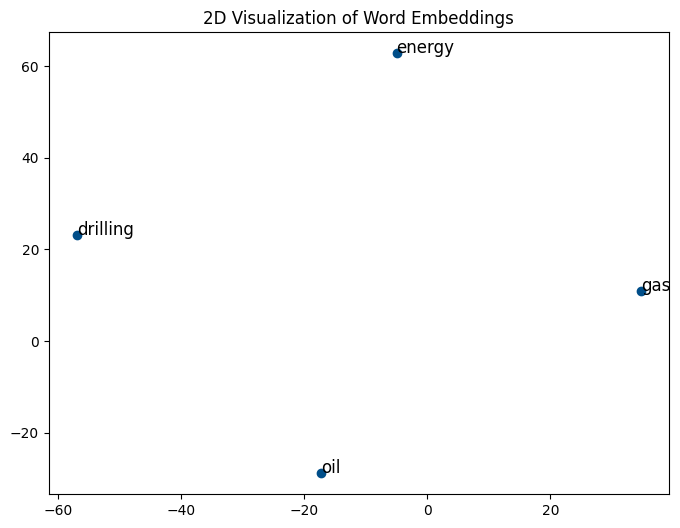

In [12]:
# Demonstrating the usefulness of trained word embedding models

# 1. Semantic similarity: Find words most similar to a given word
def most_similar_words(target_word, model, preprocessor, top_n=5):
    if target_word not in preprocessor.word_to_idx:
        print(f"'{target_word}' not in vocabulary.")
        return []
    target_idx = preprocessor.word_to_idx[target_word]
    target_vec = model.get_word_embedding(target_idx).reshape(1, -1)
    all_embeddings = model.in_embeddings.weight.detach().cpu().numpy()
    similarities = cosine_similarity(target_vec, all_embeddings)[0]
    # Get top_n most similar words (excluding the word itself)
    similar_indices = similarities.argsort()[::-1][1:top_n+1]
    similar_words = [(preprocessor.idx_to_word[idx], similarities[idx]) for idx in similar_indices]
    return similar_words

# Example: Find words similar to 'oil'
similar = most_similar_words('oil', model, preprocessor, top_n=5)
print("Words most similar to 'oil':")
for word, score in similar:
    print(f"  {word:15s} (similarity: {score:.3f})")

# 2. Word analogies: "oil" is to "gas" as "exploration" is to ?
def analogy(word_a, word_b, word_c, model, preprocessor, top_n=1):
    for w in [word_a, word_b, word_c]:
        if w not in preprocessor.word_to_idx:
            print(f"'{w}' not in vocabulary.")
            return []
    idx_a = preprocessor.word_to_idx[word_a]
    idx_b = preprocessor.word_to_idx[word_b]
    idx_c = preprocessor.word_to_idx[word_c]
    vec_a = model.get_word_embedding(idx_a)
    vec_b = model.get_word_embedding(idx_b)
    vec_c = model.get_word_embedding(idx_c)
    analogy_vec = vec_b - vec_a + vec_c
    all_embeddings = model.in_embeddings.weight.detach().cpu().numpy()
    similarities = cosine_similarity(analogy_vec.reshape(1, -1), all_embeddings)[0]
    # Exclude input words
    exclude = {idx_a, idx_b, idx_c}
    best_indices = [idx for idx in similarities.argsort()[::-1] if idx not in exclude][:top_n]
    return [(preprocessor.idx_to_word[idx], similarities[idx]) for idx in best_indices]

# Example analogy: "oil" is to "gas" as "exploration" is to ?
analogy_result = analogy('oil', 'gas', 'exploration', model, preprocessor)
print("\nAnalogy: 'oil' is to 'gas' as 'exploration' is to:")
for word, score in analogy_result:
    print(f"  {word:15s} (similarity: {score:.3f})")

# 3. Visualization: Project embeddings to 2D for inspection (optional)
def plot_embeddings(words, model, preprocessor, colors):
    # Only keep words that are in the vocabulary
    filtered_words = [w for w in words if w in preprocessor.word_to_idx]
    indices = [preprocessor.word_to_idx[w] for w in filtered_words]
    if not indices:
        print("No valid words to plot.")
        return
    embeddings = model.get_word_embedding(indices)
    if len(indices) == 1:
        embeddings = embeddings.reshape(1, -1)
    # Set perplexity to be less than the number of samples
    perplexity = max(2, min(30, len(indices) - 1))
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=perplexity)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=colors['primary'])
    for i, word in enumerate(filtered_words):
        plt.text(reduced[i, 0], reduced[i, 1], word, fontsize=12)
    plt.title("2D Visualization of Word Embeddings")
    plt.show()

# Example: Visualize a few related words
words_to_plot = ['oil', 'gas', 'exploration', 'drilling', 'pipeline', 'energy']
plot_embeddings(words_to_plot, model, preprocessor, colors)